In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

%matplotlib inline

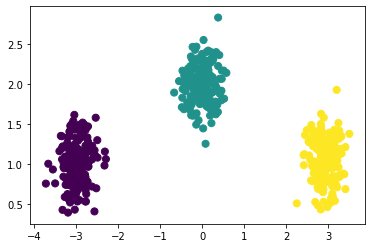

In [4]:
# Create the training data
np.random.seed(3)
X, y = make_blobs(n_samples=500,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

In [5]:
# one vs all classification
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        for i in range(len(self.estimators)):
            y_list = np.zeros(len(y))
            y_list = np.where(y==i, 1, 0)
            self.estimators[i].fit(X,y_list)
        self.fitted = True
        return self
        
    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        #Replace the following return statement with your code
        ret_row = X.shape[0]
        ret_col = self.n_classes
        ret_mat = np.zeros((ret_row, ret_col))
        for i in range(self.n_classes):
            ret_mat[:,i] = self.estimators[i].decision_function(X)
        return ret_mat
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        #Replace the following return statement with your code
        all_predicts = self.decision_function(X)
        predict = np.argmax(all_predicts, axis = 1)
        return predict

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


array([[167,   0,   0],
       [  0, 167,   0],
       [  0,   0, 166]])

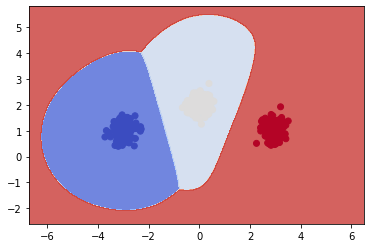

In [28]:
#Here we test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge',kernel = 'rbf', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

In [18]:
# Multiclass
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    #your code goes here, and replaces following return
    num_outFeatures = num_classes*num_inFeatures
    
    if num_samples == 1:
        feature_map = np.zeros(num_outFeatures)
        feature_map[y*num_inFeatures:(y+1)*num_inFeatures] = X
        return feature_map
    else:
        feature_mat = np.zeros((num_samples,num_outFeatures))
        for i, xi in enumerate(X):
            feature_mat[i][y[i]*num_inFeatures:(y[i]+1)*num_inFeatures] = xi
        return feature_mat

def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    w = np.zeros(num_outFeatures)
    #your code goes here and replaces following return statement
    t=1
    while(t<=T):
        random_indx = np.random.choice(500)
        w -= eta * subgd(X[random_indx], y[random_indx], w)
        t += 1
    return w


class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''
        #Your code goes here and replaces the following return statement
        temp_list = []
        for yi in range(self.num_classes):
            temp_list.append(self.Delta(y,yi)-np.dot(w, self.Psi(x,y)-self.Psi(x,yi)))
        y_hat = np.argmax(temp_list)
        g = 2*self.lam*w + self.Psi(x,y_hat)-self.Psi(x,y)
        return g
    
    def fit(self,X,y,eta=0.01,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        num_outFeatures = X.shape[1] * self.num_classes
        self.coef_ = sgd(X,y,num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
        num_samples = X.shape[0]
        #Your code goes here and replaces following return statement
        score_matrix = np.zeros((num_samples, self.num_classes))
        for i, x_i in enumerate(X):
            score_matrix[i,:] = [np.dot(self.coef_, self.Psi(x_i,yi)) for yi in range(self.num_classes)]
        return score_matrix
    
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''

        #Your code goes here and replaces following return statement
        score_matrix = self.decision_function(X)
        predicts = np.argmax(score_matrix, axis = 1)
        return predicts
                                        

w:
[-0.33974037 -0.04585242 -0.00803163  0.11999858  0.347772   -0.07414615]


array([[167,   0,   0],
       [  0, 167,   0],
       [  0,   0, 166]])

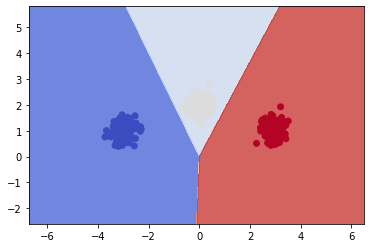

In [20]:
#the following code tests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(lam=1)
est.fit(X,y)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))